In [7]:
import requests
import rasterio
import pandas as pd
from shapely.geometry import Polygon
from pystac_client import Client
from planetary_computer import sign

# Step 1: Define your AOI Polygon (example coordinates)
aoi = Polygon([[-105.1, 39.7], [-105.1, 39.8], [-105.0, 39.8], [-105.0, 39.7]])

# Step 2: Define the STAC API endpoint for Planetary Computer
stac_api_url = "https://planetarycomputer.microsoft.com/api/stac/v1"

# Initialize the STAC client
client = Client.open(stac_api_url)

# Step 3: Search for Landsat data
search = client.search(
    collections=["landsat-8-c2-l2"],
    intersects=aoi,
    datetime="2021-01-01/2021-12-31",
    limit=1  # Adjust based on your need
)

# Step 4: Retrieve the items using item_collection()
items = search.item_collection()

if not items:
    print("No items found.")
    exit()

item = items.items[0]  # Use the first item found

# Step 5: Define the bands you want to retrieve
bands = ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7"]

# Prepare a list to hold the data
data = []

# Step 6: Loop through each band, read the data, and collect it in the table
for band in bands:
    if band in item.assets:
        asset = item.assets[band]
        signed_href = sign(asset.href)  # Sign the URL using Planetary Computer's helper function

        # Read the raster data using rasterio
        with rasterio.open(signed_href) as src:
            band_data = src.read(1).flatten()  # Read and flatten the data to a 1D array
            band_labels = [band] * len(band_data)  # Create a list of the band name repeated for each pixel

            # Combine the band label and the reflectance values
            data.extend(zip(band_labels, band_data))
    else:
        print(f"Band {band} not found in the item.")

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data, columns=['band', 'Landsat 8'])



In [9]:
# Display the DataFrame

import ace_tools as tools
tools.display_dataframe_to_user(name="Landsat Reflectance Data", dataframe=df)


ModuleNotFoundError: No module named 'ace_tools'

In [8]:
df.to_csv("landsat_reflectance_data.csv", index=True)

In [12]:
df2 = pd.read_csv('landsat_reflectance_data.csv', nrows=1000)
print(df2)

     Unnamed: 0   band  Landsat 8
0             0  SR_B1          0
1             1  SR_B1          0
2             2  SR_B1          0
3             3  SR_B1          0
4             4  SR_B1          0
..          ...    ...        ...
995         995  SR_B1          0
996         996  SR_B1          0
997         997  SR_B1          0
998         998  SR_B1          0
999         999  SR_B1          0

[1000 rows x 3 columns]


<Figure size 1000x600 with 0 Axes>

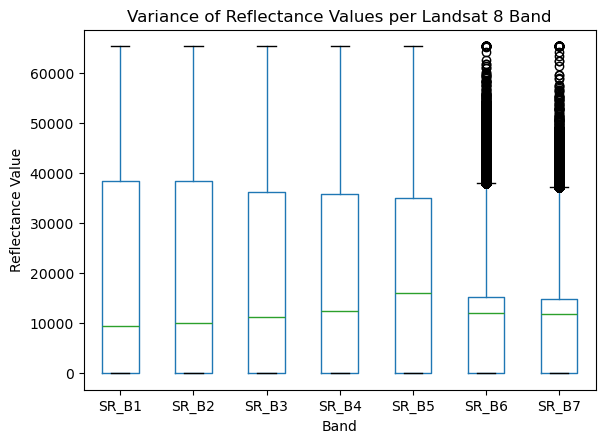

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is already loaded with 'band' and 'Landsat 8' reflectance values
# Creating a box and whisker plot

plt.figure(figsize=(10, 6))
df.boxplot(column='Landsat 8', by='band', grid=False)
plt.title('Variance of Reflectance Values per Landsat 8 Band')
plt.suptitle('')  # Suppress the automatic title from pandas
plt.xlabel('Band')
plt.ylabel('Reflectance Value')
plt.show()
